In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy

import matplotlib.pylab as plt
%matplotlib inline

import statsmodels.formula.api as sm
from scipy.stats import skew

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import plotDecisionTree, gainsChart, liftChart
from dmba import classificationSummary, regressionSummary

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge, SGDRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, plot_tree
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix,r2_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler


import statsmodels.tools.tools as stattools


from wsgiref.simple_server import WSGIRequestHandler
from sklearn import preprocessing



In [4]:
df= pd.read_csv('https://raw.githubusercontent.com/VSbr22/ADS505B-Fall22-Group-1/main/Global_Superstore2.csv')

In [51]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,31-07-2012,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,05-02-2013,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2013-71249,17-10-2013,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
3,13524,ES-2013-1579342,28-01-2013,30-01-2013,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
4,47221,SG-2013-4320,05-11-2013,06-11-2013,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical


In [52]:
df.dtypes

Row ID              int64
Order ID           object
Order Date         object
Ship Date          object
Ship Mode          object
Customer ID        object
Customer Name      object
Segment            object
City               object
State              object
Country            object
Postal Code       float64
Market             object
Region             object
Product ID         object
Category           object
Sub-Category       object
Product Name       object
Sales             float64
Quantity            int64
Discount          float64
Profit            float64
Shipping Cost     float64
Order Priority     object
dtype: object

In [53]:
df.shape

(51290, 24)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          51290 non-null  int64  
 1   Order ID        51290 non-null  object 
 2   Order Date      51290 non-null  object 
 3   Ship Date       51290 non-null  object 
 4   Ship Mode       51290 non-null  object 
 5   Customer ID     51290 non-null  object 
 6   Customer Name   51290 non-null  object 
 7   Segment         51290 non-null  object 
 8   City            51290 non-null  object 
 9   State           51290 non-null  object 
 10  Country         51290 non-null  object 
 11  Postal Code     9994 non-null   float64
 12  Market          51290 non-null  object 
 13  Region          51290 non-null  object 
 14  Product ID      51290 non-null  object 
 15  Category        51290 non-null  object 
 16  Sub-Category    51290 non-null  object 
 17  Product Name    51290 non-null 

In [55]:
df.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit,Shipping Cost
count,51290.00000,9994.000000,51290.000000,51290.000000,51290.000000,51290.000000,51290.000000
mean,25645.50000,55190.379428,246.490581,3.476545,0.142908,28.610982,26.375915
std,14806.29199,32063.693350,487.565361,2.278766,0.212280,174.340972,57.296804
min,1.00000,1040.000000,0.444000,1.000000,0.000000,-6599.978000,0.000000
25%,12823.25000,23223.000000,30.758625,2.000000,0.000000,0.000000,2.610000
50%,25645.50000,56430.500000,85.053000,3.000000,0.000000,9.240000,7.790000
75%,38467.75000,90008.000000,251.053200,5.000000,0.200000,36.810000,24.450000
max,51290.00000,99301.000000,22638.480000,14.000000,0.850000,8399.976000,933.570000


In [5]:
# Skewed predictors
print('Sales Skew:', skew(df['Sales'], axis = 0, bias = True ))
print('Quantity Skew:', skew(df['Quantity'], axis = 0, bias = True ))
print('Discount Skew:', skew(df['Discount'], axis = 0, bias = True ))
print('Profit Skew:', skew(df['Profit'], axis = 0, bias = True ))
print('Shipping Cost Skew:', skew(df['Shipping Cost'], axis = 0, bias = True ))

Sales Skew: 8.137842017336732
Quantity Skew: 1.3603279457897046
Discount Skew: 1.3877339656893208
Profit Skew: 4.157066952869827
Shipping Cost Skew: 5.863054951522988


In [6]:
#Format column names
df.columns = [d.replace(' ', '_') for d in df.columns]
df.columns = [d.replace('-', '_') for d in df.columns]


In [57]:
# find missing values within the data
df.isnull().sum(axis = 0)

Row_ID                0
Order_ID              0
Order_Date            0
Ship_Date             0
Ship_Mode             0
Customer_ID           0
Customer_Name         0
Segment               0
City                  0
State                 0
Country               0
Postal_Code       41296
Market                0
Region                0
Product_ID            0
Category              0
Sub_Category          0
Product_Name          0
Sales                 0
Quantity              0
Discount              0
Profit                0
Shipping_Cost         0
Order_Priority        0
dtype: int64

In [7]:
# Rows containing duplicate data
duplicate_rows_df = df[df.duplicated()]
print(" number of duplicate rows:", duplicate_rows_df)

 number of duplicate rows: Empty DataFrame
Columns: [Row_ID, Order_ID, Order_Date, Ship_Date, Ship_Mode, Customer_ID, Customer_Name, Segment, City, State, Country, Postal_Code, Market, Region, Product_ID, Category, Sub_Category, Product_Name, Sales, Quantity, Discount, Profit, Shipping_Cost, Order_Priority]
Index: []

[0 rows x 24 columns]


In [58]:
#format data and time correctly
df['Order_Date'] = pd.to_datetime(df['Order_Date'], infer_datetime_format=True)
df['Ship_Date'] = pd.to_datetime(df['Ship_Date'], infer_datetime_format=True)

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row_ID          51290 non-null  int64         
 1   Order_ID        51290 non-null  object        
 2   Order_Date      51290 non-null  datetime64[ns]
 3   Ship_Date       51290 non-null  datetime64[ns]
 4   Ship_Mode       51290 non-null  object        
 5   Customer_ID     51290 non-null  object        
 6   Customer_Name   51290 non-null  object        
 7   Segment         51290 non-null  object        
 8   City            51290 non-null  object        
 9   State           51290 non-null  object        
 10  Country         51290 non-null  object        
 11  Postal_Code     9994 non-null   float64       
 12  Market          51290 non-null  object        
 13  Region          51290 non-null  object        
 14  Product_ID      51290 non-null  object        
 15  Ca

In [61]:
df = df.drop(columns=['Customer_Name', 'Postal_Code'])

In [62]:
df.describe()

,Row_ID,Sales,Quantity,Discount,Profit,Shipping_Cost
count,51290.00000,51290.000000,51290.000000,51290.000000,51290.000000,51290.000000
mean,25645.50000,246.490581,3.476545,0.142908,28.610982,26.375915
std,14806.29199,487.565361,2.278766,0.212280,174.340972,57.296804
min,1.00000,0.444000,1.000000,0.000000,-6599.978000,0.000000
25%,12823.25000,30.758625,2.000000,0.000000,0.000000,2.610000
50%,25645.50000,85.053000,3.000000,0.000000,9.240000,7.790000
75%,38467.75000,251.053200,5.000000,0.200000,36.810000,24.450000
max,51290.00000,22638.480000,14.000000,0.850000,8399.976000,933.570000


In [63]:
# Coerce categories as needed for analysis 
df['Ship_Mode']= df['Ship_Mode'].astype('category')
df['Segment']= df['Segment'].astype('category')
df['Country']= df['Country'].astype('category')
df['Market']= df['Market'].astype('category')
df['Region']= df['Region'].astype('category')
df['Category']= df['Category'].astype('category')
df['Sub_Category']= df['Sub_Category'].astype('category')
df['Order_Priority']= df['Order_Priority'].astype('category')

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row_ID          51290 non-null  int64         
 1   Order_ID        51290 non-null  object        
 2   Order_Date      51290 non-null  datetime64[ns]
 3   Ship_Date       51290 non-null  datetime64[ns]
 4   Ship_Mode       51290 non-null  category      
 5   Customer_ID     51290 non-null  object        
 6   Segment         51290 non-null  category      
 7   City            51290 non-null  object        
 8   State           51290 non-null  object        
 9   Country         51290 non-null  category      
 10  Market          51290 non-null  category      
 11  Region          51290 non-null  category      
 12  Product_ID      51290 non-null  object        
 13  Category        51290 non-null  category      
 14  Sub_Category    51290 non-null  category      
 15  Pr

In [65]:
# How many Order ID's per country? 
df.groupby(['Country']).count()[['Order_ID']]

,Order_ID
Country,
Afghanistan,55
Albania,16
Algeria,196
Angola,122
Argentina,390
...,...
Venezuela,194
Vietnam,265
Yemen,30


In [66]:
#how many orders per city
df.groupby(['City']).count()[['Order_ID']]

,Order_ID
City,
Aachen,17
Aalen,1
Aalst,4
Aba,25
Abadan,11
...,...
Zwedru,1
Zwickau,3
Zwolle,2


In [83]:
#Which country purchases the highest quanitity of goods from the superstore
biggest_procurement = df.groupby(['Country']).sum()[['Quantity']].nlargest(n=10, columns=['Quantity'])
biggest_procurement

,Quantity
Country,
United States,37873
France,10804
Australia,10673
Mexico,10011
Germany,7745
China,7081
United Kingdom,6161
Brazil,6148
India,5758


In [90]:
# which product is the most profitable
most_profitable_product = df.groupby(['Product_Name']).sum()[['Profit']].nlargest(n=5, columns=['Profit'])
most_profitable_product

,Profit
Product_Name,
Canon imageCLASS 2200 Advanced Copier,25199.9280
"Cisco Smart Phone, Full Size",17238.5206
"Motorola Smart Phone, Full Size",17027.1130
"Hoover Stove, Red",11807.9690
"Sauder Classic Bookcase, Traditional",10672.0730


In [85]:
# which country is the most profitable
most_profitable_country = df.groupby(['Country']).sum()[['Profit']].nlargest(n=5, columns=['Profit'])
most_profitable_country

,Profit
Country,
United States,286397.0217
China,150683.0850
India,129071.8350
United Kingdom,111900.1500
France,109029.0030


In [11]:
# How many product ID's are there? How many Product Names?
print('There are', df['Product_ID'].nunique(), 'unique product IDs, and', 
      df['Product_Name'].nunique(), ' unique product names')


# There are only 3788 Unique products, but some go by different ID's

group = pd.DataFrame(df.groupby('Product_Name')['Product_ID'].unique())
group['Product_ID'] = group['Product_ID'].astype('str')
group['#Product_IDs'] = group['Product_ID'].str.split(' ').apply(len)

products  = group.sort_values(by = ['#Product_IDs'], ascending = False)
products.head()

There are 10292 unique product IDs, and 3788  unique product names


,Product_ID,#Product_IDs
Product_Name,,
Staples,['OFF-EN-10004773' 'OFF-EN-10003286' 'OFF-PA-1...,46
"Stockwell Paper Clips, Assorted Sizes",['OFF-FA-10002017' 'OFF-FA-10004265' 'OFF-FA-1...,16
"Acco Index Tab, Clear",['OFF-BI-10002738' 'OFF-BI-10002386' 'OFF-BI-1...,12
"HP Copy Machine, Color",['TEC-CO-10004563' 'TEC-CO-10003901' 'TEC-HP -...,12
"Stockwell Push Pins, 12 Pack",['OFF-FA-10002577' 'OFF-FA-10002790' 'OFF-FA-1...,11


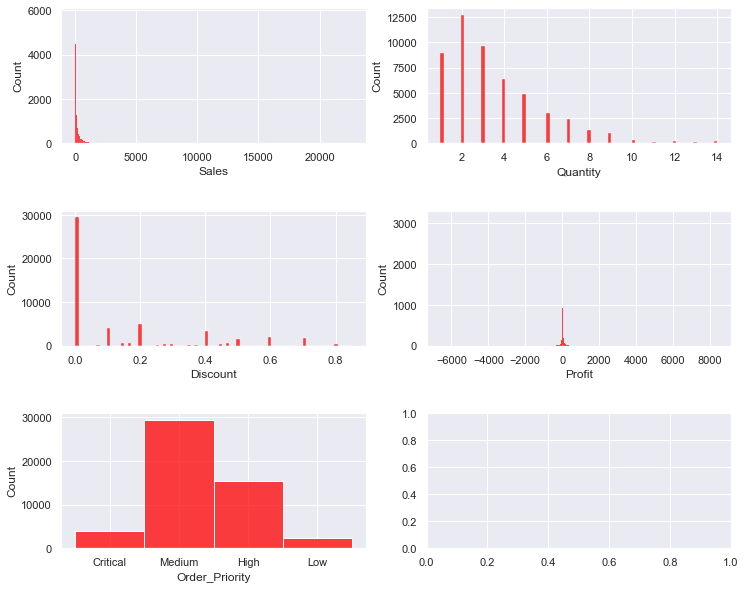

In [12]:
# Plot numeric histograms here

sns.set(font_scale=1)
fig, axs = plt.subplots(3, 2, figsize = (12,12))
fig.subplots_adjust(hspace=0.5, top = 0.75)

sns.histplot(df['Sales'], color="red", ax=axs[0, 0])
sns.histplot(df['Quantity'], color="red", ax=axs[0, 1])
sns.histplot(df['Discount'], color="red", ax=axs[1, 0])
sns.histplot(df['Profit'], color="red", ax=axs[1, 1])
sns.histplot(df['Order_Priority'], color="red", ax=axs[2, 0])

plt.show()

In [14]:
# # Plot categorical histograms here

# # sns.set(font_scale=1)
# fig, axs = plt.subplots(2, 5, figsize=(12, 12))
# fig.subplots_adjust(hspace=0.5, top = 0.75)

# chart = sns.countplot(x=df['Ship_Mode'], color="red", ax=axs[0, 0])
# chart.set_xticklabels(chart.get_xticklabels(), rotation=20, horizontalalignment='right')

# chart = sns.countplot(x=df['Segment'], color="red", ax=axs[0, 1])
# chart.set_xticklabels(chart.get_xticklabels(), rotation=20, horizontalalignment='right')

# chart = sns.countplot(x=df['City'], color="red", ax=axs[0, 2])
# chart.set_xticklabels(chart.get_xticklabels(), rotation=20, horizontalalignment='right')

# chart = sns.countplot(x=df['State'], color="red", ax=axs[0, 3])
# chart.set_xticklabels(chart.get_xticklabels(), rotation=20, horizontalalignment='right')

# chart = sns.countplot(x=df['Country'], color="red", ax=axs[0, 4])
# chart.set_xticklabels(chart.get_xticklabels(), rotation=20, horizontalalignment='right')

# chart = sns.countplot(x=df['Market'], color="red", ax=axs[1, 0])
# chart.set_xticklabels(chart.get_xticklabels(), rotation=20, horizontalalignment='right')

# chart = sns.countplot(x=df['Region'], color="red", ax=axs[1, 1])
# chart.set_xticklabels(chart.get_xticklabels(), rotation=20, horizontalalignment='right')

# chart = sns.countplot(x=df['Category'], color="red", ax=axs[1, 2])
# chart.set_xticklabels(chart.get_xticklabels(), rotation=20, horizontalalignment='right')

# chart = sns.countplot(x=df['Sub_Category'], color="red", ax=axs[1, 3])
# chart.set_xticklabels(chart.get_xticklabels(), rotation=20, horizontalalignment='right')

# chart = sns.countplot(x=df['Product_Name'], color="red", ax=axs[1, 4])
# chart.set_xticklabels(chart.get_xticklabels(), rotation=20, horizontalalignment='right')
# plt.show()

In [16]:
# # Plot binary histograms here
# binary = x=(np.where(df['Profit']) > 0, 1, 0)
# sns.set(font_scale=1)
# chart = sns.countplot(binary , color="red", figsize=(12, 12))
# plt.show()

In [20]:
# How many customer ID's are there? How many customer Names?
print('There are', df['Customer_ID'].nunique(), 'unique Customer IDs, and', 
      df['Customer_Name'].nunique(), ' unique Customer names')

# There are only 795 Unique customers, each having 2 customer ID's that look similar 

group1 = pd.DataFrame(df.groupby('Customer_Name')['Customer_ID'].unique())
group1['Customer_ID'] = group1['Customer_ID'].astype('str')
group1['#Customer_IDs'] = group1['Customer_ID'].str.split(' ').apply(len)

customers  = group1.sort_values(by = ['#Customer_IDs'], ascending = False)
customers.tail()

# It seems that there are two Customer ID's for each Name - Redundant 

There are 1590 unique Customer IDs, and 795  unique Customer names


,Customer_ID,#Customer_IDs
Customer_Name,,
Erica Smith,['ES-14020' 'ES-4020'],2
Erin Ashbrook,['EA-14035' 'EA-4035'],2
Erin Creighton,['EC-14050' 'EC-4050'],2
Erin Mull,['EM-14065' 'EM-4065'],2
Zuschuss Donatelli,['ZD-21925' 'ZD-11925'],2


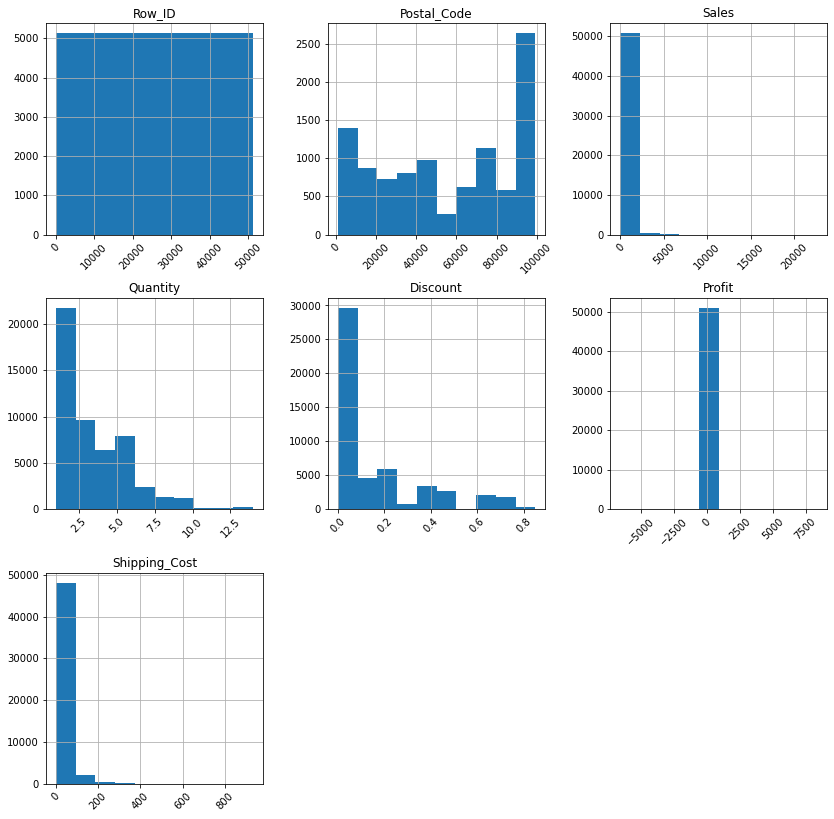

In [8]:
df.hist(figsize=(14,14), xrot=45)
plt.show()

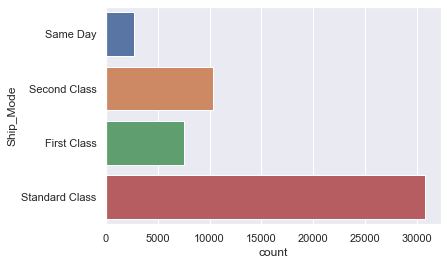

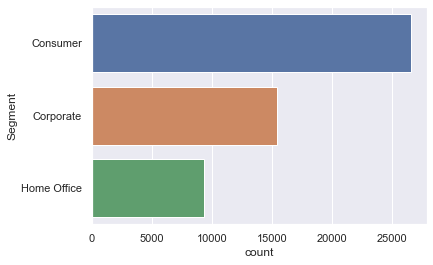

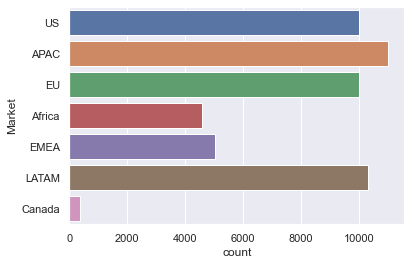

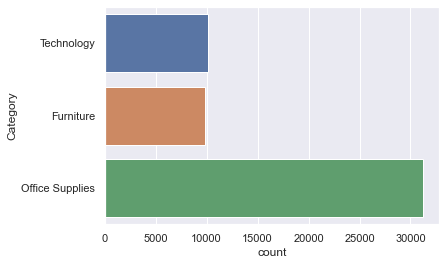

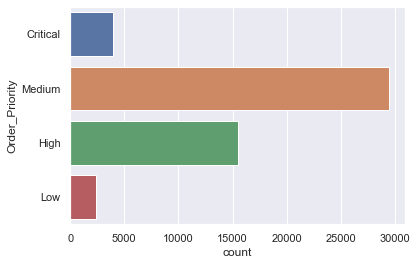

In [21]:
for column in df.select_dtypes(include='object'):
    if df[column].nunique() < 10:
        sns.countplot(y=column, data=df)
        plt.show()

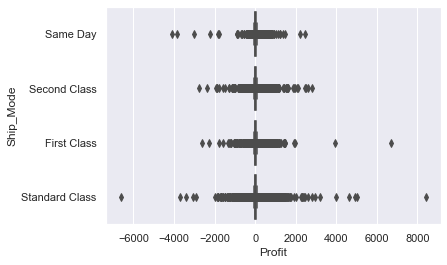

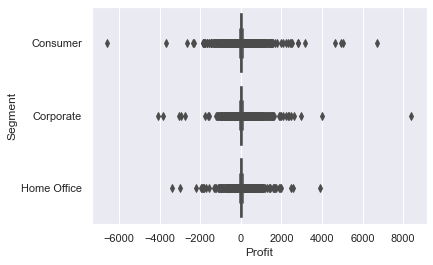

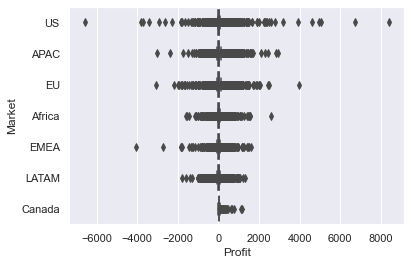

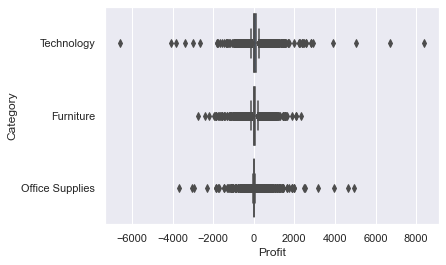

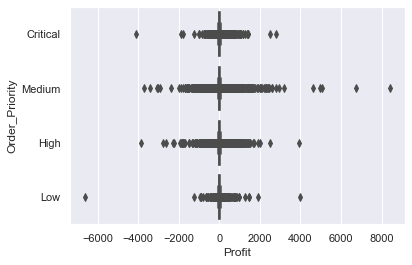

In [22]:
for column in df.select_dtypes(include='object'):
 if df[column].nunique() < 10:
    sns.boxplot(y=column, x='Profit', data=df) 
    plt.show()

In [23]:
for column in df.select_dtypes(include='object'):
    if df[column].nunique() < 10:
        display(df.groupby(column).mean())

,Row_ID,Postal_Code,Sales,Quantity,Discount,Profit,Shipping_Cost
Ship_Mode,,,,,,,
First Class,25795.386276,54765.611834,243.967507,3.469554,0.148898,27.728804,41.053065
Same Day,26447.277305,57536.082873,247.020357,3.417253,0.143525,28.201802,42.937453
Second Class,25693.750994,55626.009254,248.876873,3.465322,0.140620,28.381368,30.469747
Standard Class,25522.415792,54944.447051,246.260020,3.487214,0.142159,28.938945,19.971755


,Row_ID,Postal_Code,Sales,Quantity,Discount,Profit,Shipping_Cost
Segment,,,,,,,
Consumer,25615.618297,55649.895781,245.416299,3.475262,0.143602,28.254008,26.295371
Corporate,25606.789228,54482.228477,247.890176,3.471709,0.142931,28.596042,26.604087
Home Office,25794.239324,55051.998317,247.228403,3.488173,0.140897,29.648847,26.227720


,Row_ID,Postal_Code,Sales,Quantity,Discount,Profit,Shipping_Cost
Market,,,,,,,
APAC,25795.500000,NaN,325.917481,3.747137,0.148839,39.629163,35.190430
Africa,46223.183344,NaN,170.868370,2.303030,0.156704,19.374674,19.215058
Canada,46487.111979,NaN,174.292109,2.169271,0.000000,46.399453,19.285495
EMEA,46336.887453,NaN,160.302508,2.290117,0.196083,8.728966,17.573221
EU,15294.500000,NaN,293.808906,3.777300,0.103105,37.282974,30.942235
LATAM,5147.500000,NaN,210.278334,3.742568,0.135531,21.531328,22.745153
US,36293.500000,55190.379428,229.858001,3.789574,0.156203,28.656896,23.831678


,Row_ID,Postal_Code,Sales,Quantity,Discount,Profit,Shipping_Cost
Category,,,,,,,
Furniture,24451.996760,55726.556341,416.248905,3.539287,0.168087,28.878567,44.584919
Office Supplies,26073.185304,54890.951211,121.097120,3.459278,0.137409,16.578961,12.964899
Technology,25488.911449,55551.572279,467.858939,3.468691,0.135342,65.454958,49.999876


,Row_ID,Postal_Code,Sales,Quantity,Discount,Profit,Shipping_Cost
Order_Priority,,,,,,,
Critical,26046.747457,54771.961686,250.822854,3.417854,0.136516,31.593124,59.721333
High,25751.321141,55597.518410,245.632420,3.485001,0.143341,27.119122,32.871887
Low,24655.840347,58667.250000,234.251621,3.422855,0.142200,24.197958,27.076448
Medium,25617.670574,54765.879159,247.371738,3.484354,0.143592,29.361729,18.442428


In [24]:
corrMatrix = df.corr()

<AxesSubplot:>

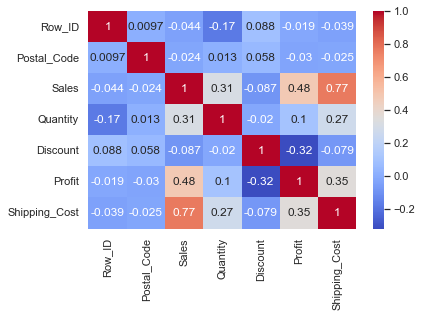

In [25]:
sns.heatmap(corrMatrix, annot = True, cmap= 'coolwarm')

## Data Preprocessing

In [26]:
df.columns

Index(['Row_ID', 'Order_ID', 'Order_Date', 'Ship_Date', 'Ship_Mode',
       'Customer_ID', 'Customer_Name', 'Segment', 'City', 'State', 'Country',
       'Postal_Code', 'Market', 'Region', 'Product_ID', 'Category',
       'Sub_Category', 'Product_Name', 'Sales', 'Quantity', 'Discount',
       'Profit', 'Shipping_Cost', 'Order_Priority'],
      dtype='object')

In [27]:
# Feature Selection, comment out features to drop 
numeric = df[[
    'Sales', 
    'Quantity', 
    'Discount',
    'Profit', 
    'Shipping_Cost'
]]

ordinal = pd.DataFrame(df['Order_Priority'])

categorical = df[[
#    'Row_ID', 
#    'Order_ID', 
#    'Order_Date', 
#    'Ship_Date', 
#    'Ship_Mode',
#    'Customer_ID', 
#    'Customer_Name', 
    'Segment', 
    'City', 
    'State', 
    'Country',
#    'Postal_Code', 
    'Market', 
    'Region', 
#    'Product_ID', 
    'Category',
    'Sub_Category', 
    'Product_Name'
]]

In [28]:
# Ordinal Encoding 
dict = {'Critical': 4, 'Medium' : 3, 'High' : 2, 'Low': 1}
ordinal = ordinal.replace({'Order_Priority': dict})
ordinal.head()

,Order_Priority
0,4
1,4
2,3
3,3
4,4


In [29]:
df.columns

Index(['Row_ID', 'Order_ID', 'Order_Date', 'Ship_Date', 'Ship_Mode',
       'Customer_ID', 'Customer_Name', 'Segment', 'City', 'State', 'Country',
       'Postal_Code', 'Market', 'Region', 'Product_ID', 'Category',
       'Sub_Category', 'Product_Name', 'Sales', 'Quantity', 'Discount',
       'Profit', 'Shipping_Cost', 'Order_Priority'],
      dtype='object')

In [30]:
# create binary variable that = 1 if positive profit and = 0 if negative profit 
profitable = pd.DataFrame(np.where(df['Profit'] > 0, 1, 0), columns = ['Profitable'])
profitable.head()

,Profitable
0,1
1,0
2,1
3,0
4,1


In [31]:
# categorical variables - dummy encode
s1 = pd.get_dummies(categorical)

#numerical variables - normalize 
s2 = pd.DataFrame(MinMaxScaler().fit_transform(numeric), columns = numeric.columns)

# add target variables (no preprocessing)
s3 = profitable 

In [32]:

df = (pd.concat([s1,s2, s3], axis = 1)).dropna()
df.head()

,Segment_Consumer,Segment_Corporate,Segment_Home Office,City_Aachen,City_Aalen,City_Aalst,City_Aba,City_Abadan,City_Abakaliki,City_Abbeville,...,Product_Name_iOttie HLCRIO102 Car Mount,Product_Name_iOttie XL Car Mount,Product_Name_invisibleSHIELD by ZAGG Smudge-Free Screen Protector,Product_Name_netTALK DUO VoIP Telephone Service,Sales,Quantity,Discount,Profit,Shipping_Cost,Profitable
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.102006,0.461538,0.000000,0.490812,1.000000,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.163837,0.615385,0.117647,0.420749,0.989353,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.228586,0.615385,0.117647,0.501331,0.980633,1
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0.127753,0.307692,0.117647,0.433564,0.974924,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.125122,0.538462,0.000000,0.460768,0.967298,1


In [33]:
# Split into X/ Y 
X = df.drop(columns=['Profitable','Profit'])
y = df['Profitable']   # classification target

#Split into Train/Test - Regression 
X_train, X_valid, y_train, y_valid= train_test_split(X, y, test_size=0.2, random_state=47)

In [34]:
# Logistic Regression -  Classification 
logr = LogisticRegression(penalty = 'l2', C = 1e12, solver = 'liblinear').fit(X_train, y_train)

# obtaining accuracy scores for logistic regression model 
print(f'training model score:{logr.score(X_train, y_train)}')
print(f'test model score:{logr.score(X_valid, y_valid)}')
#print('R2 Value:', r2_score(y_valid, logr.predict(X_train)))

training model score:0.9708032754922987
test model score:0.9208422694482356


In [36]:
# reassign y to classification target variable 
y = df['Profit']

In [37]:
# Linear Regression -  Regression
lr = LinearRegression().fit(X_train, y_train)

# obtaining accuracy scores for logistic regression model 
print(f'training model score:{lr.score(X_train, y_train)}')
print(f'test model score:{lr.score(X_valid, y_valid)}')
#print('R2 Value:', r2_score(y_valid, lr.predict(X_train)))

training model score:0.765934406193459
test model score:-6.364054517454723e+21


In [38]:
# Support Vector Machine -  Regression
svm = SVR(C = 2, kernel = 'linear', max_iter = 1000).fit(X_train, y_train)

# obtaining accuracy scores for logistic regression model 
print(f'training model score:{svm.score(X_train, y_train)}')
print(f'test model score:{svm.score(X_valid, y_valid)}')
#print('R2 Value:',metrics.r2_score(y_valid, SVM.predict(X_train)))

/Users/vannesasalazar/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


training model score:0.18353450932665016
test model score:0.18487398468787009
